Scratch Jupyter Noteboook

In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from matplotlib import cm
import tqdm  
import activations
import params
%matplotlib inline

# Parameters

In [ ]:

import activations
from params import FlattenOrder

nonlinear_params = {
    'alpha': 900,
    'beta':  -.06045,
    'r': 3.99,
    'mu': 1.99
}

num_samples_train = 10000
num_samples_test = 1000


config = params.RegressionParams(
    width = 1000,
    depth = 50,
    input_dimension = 2,
    transform_type = activations.TransformType.TENT,
    transform_params = params.TentParams(
        mu = 1.99
    ), 
    output_dimension=1,
    flatten_order=FlattenOrder.AUTO
)

ValidationError: 1 validation error for RegressionParams
transform_type
  Input should be an instance of TransformType [type=is_instance_of, input_value=<function tent at 0x7fc87d696b60>, input_type=function]
    For further information visit https://errors.pydantic.dev/2.11/v/is_instance_of

# Function Definitions

In [8]:

def xor(x: NDArray) -> int:

    if x[0] >= 0:
        # First or Fourth Quadrants
        if x[1] >= 0:
            # First Quadrant
                return 0
            # Fourth Quadrant
        else:
            return 1
        
    # Second or Third Quadrants
    else:
        # Second Quadrant
        if x[1] >= 0:
            return 1
        
        # Fourth Quadrant
        else:
            return 0

# Neuron Preferred Directions

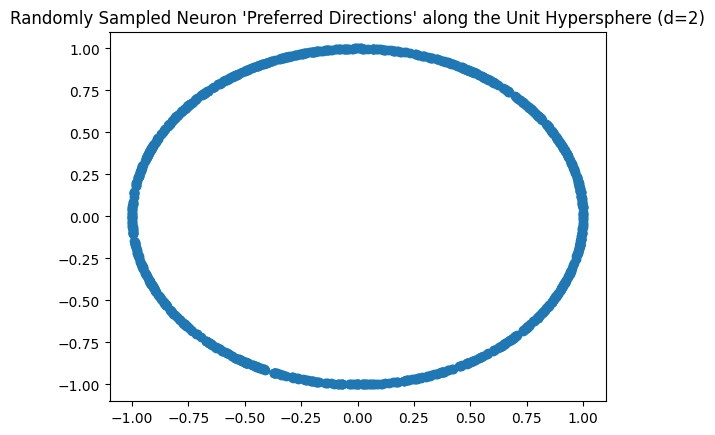

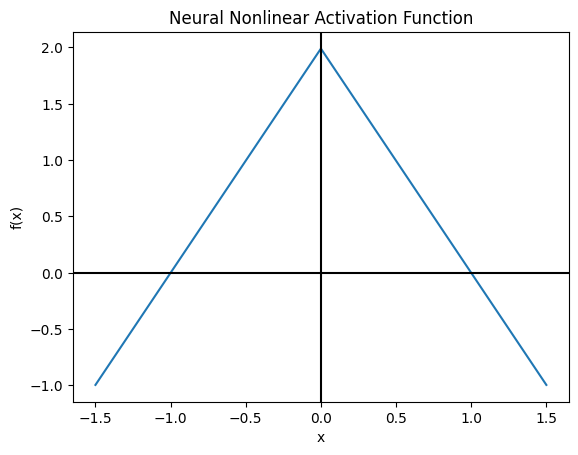

In [9]:
neurons = np.random.normal(loc=0, scale=1, size=(config.input_dimension, config.width))
neurons = neurons / np.linalg.norm(neurons, axis=0)
neurons = np.asarray(neurons)
plt.scatter(neurons[0,:], neurons[1,:])
plt.title("Randomly Sampled Neuron 'Preferred Directions' along the Unit Hypersphere (d=2)")
plt.show()

plt.title("Neural Nonlinear Activation Function")
xs = np.asarray(np.linspace(-1.5, 1.5, num=1000))
# plt.plot(xs, gauss(xs, alpha=nonlinear_params['alpha'], beta=nonlinear_params['beta']))
plt.plot(xs, activations.tent(xs, params=config.transform_params))

# plt.xlim([-1, 1])
# plt.ylim(-1,1)
plt.xlabel("x")
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.ylabel("f(x)")
plt.show()


# Topological Mixing

/tmp/ipykernel_128596/1203728560.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('inferno', config.depth+1)
/tmp/ipykernel_128596/1203728560.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(activations_identity[idx_layer, :, 0], activations_identity[idx_layer, :, 1], label=f"Pass {idx_layer+1}", c=colors(idx_layer+1))


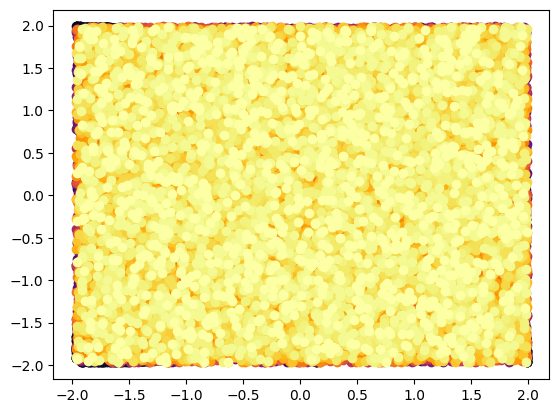

In [10]:
colors = cm.get_cmap('inferno', config.depth+1)


activations_identity = activations.compute_activations(neurons, np.asarray(np.eye(2)), config)


plt.scatter(neurons[0,:], neurons[1,:], color="black")
for idx_layer in range(1,config.depth): 
    plt.scatter(activations_identity[idx_layer, :, 0], activations_identity[idx_layer, :, 1], label=f"Pass {idx_layer+1}", c=colors(idx_layer+1))
    
# plt.xlim([-1.25, 1.25])
# plt.ylim([-1.25, 1.25])
# plt.legend()
plt.show()

# XOR Example 

In [ ]:



# acts has shape (depth, num_neurons, num_samples)
test_samples = np.random.normal(loc=0, scale=1, size=(config.input_dimension, num_samples_test))
test_samples /= np.linalg.norm(test_samples,axis=0)
train_samples = np.random.normal(loc=0, scale=1, size=(num_dims, num_samples_train))
train_samples /= np.linalg.norm(train_samples,axis=0)

# Scale by radii distributed according to d^th root (where d is dimension) to get uniform density 
test_radii = np.random.uniform(0, 1, size=num_samples_test)
train_radii = np.random.uniform(0, 1, size=num_samples_train)
test_samples *= np.sqrt(test_radii)
train_samples *= np.sqrt(train_radii)


# Batch compute activations
activations_train = forward_pass(neurons, input_x=train_samples, n_layers=depth, params=nonlinear_params) # np.zeros((n_layers, num_neurons, num_samples_train)) 
activations_test =  forward_pass(neurons, input_x=test_samples, n_layers=depth, params=nonlinear_params) # np.zeros((n_layers, num_neurons, num_samples_train)) 


# Compute XOR, then use making to plot classification
xors_train = np.array([xor(train_samples[:, i]) for i in range(num_samples_train)])

mask_0 = xors_train == 0
mask_1 = xors_train == 1
plt.scatter(train_samples[0,mask_0], train_samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(train_samples[0,mask_1], train_samples[1,mask_1], c='green', marker='o', label='XOR = 1')
        
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

plt.title("XOR Function")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

    

# Train an XOR Decoder

In [ ]:
# acts has shape (depth, num_neurons, num_samples)
acts_flat = activations_train.reshape((depth*num_neurons, num_samples_train))

decoder = np.linalg.lstsq(acts_flat.T, xors_train)[0]Lo

xors_recovered = decoder @ acts_flat


In [ ]:
xor_thresh = 0.5 

mask_0 = np.isclose(xors_recovered, 0)
mask_1 = np.isclose(xors_recovered, 1)
plt.scatter(train_samples[0,mask_0], train_samples[1,mask_0], c='red', marker='x', label='XOR = 0')
plt.scatter(train_samples[0,mask_1], train_samples[1,mask_1], c='green', marker='o', label='XOR = 1')

xors_train_rounded = xors_recovered.copy()
xors_train_rounded[xors_train_rounded <= xor_thresh] = 0
xors_train_rounded[xors_train_rounded > xor_thresh] = 1
xor_train_actual = np.array([xor(train_samples[:, i]) for i in range(train_samples.shape[1])])

for i in range(train_samples.shape[1]):
    if xors_train_rounded[i] != xor_train_actual[i]:
        plt.scatter(train_samples[0,i], train_samples[1,i], marker='+',c='yellow')
        
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

plt.title(f"Network Approximation of XOR function  (Applied to Training Data)\nAccuracy = {100 *sum(xors_train_rounded==xor_train_actual)/num_samples_train}%")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

In [ ]:
xors_test_recovered = decoder @ activations_test.reshape((depth*num_neurons, num_samples_test))
plt.hist(xors_test_recovered)



# Test XOR Approximation

In [ ]:
xors_test_recovered = decoder @ activations_test.reshape((depth*num_neurons, num_samples_test))
xors_test_recovered[xors_test_recovered <=  xor_thresh] = 0
xors_test_recovered[xors_test_recovered >  xor_thresh] = 1

mask_test_0 = xors_test_recovered  <= xor_thresh
mask_test_1 = xors_test_recovered  > xor_thresh
plt.scatter(test_samples[0,mask_test_0], test_samples[1,mask_test_0], c='red', marker='x', label='XOR = 0')
plt.scatter(test_samples[0,mask_test_1], test_samples[1,mask_test_1], c='green', marker='o', label='XOR = 1')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
    
xors_test_actual = np.array([xor(test_samples[:, i]) for i in range(num_samples_test)])

# for i in range(num_samples_test):
#     if not xors_test_recovered[i] == xors_test_actual[i]:
#         plt.scatter(test_samples[0,i], test_samples[1,i], marker='+',c='yellow')
        

plt.title(f"Network Approximation of XOR function  (Applied to Test Data)\nAccuracy = {100 *sum(xors_test_recovered==xors_test_actual)/num_samples_test}%")
plt.axis('equal')
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

# Layer-based Training + Test Errors

In [ ]:
decoders =[]
for idx_layer in tqdm.tqdm(range(depth)):
    acts_flat = activations_train[:idx_layer,:, :].reshape((idx_layer*num_neurons, num_samples_train))
    decoders.append(np.linalg.lstsq(acts_flat.T, xors_train)[0])

In [ ]:
# for decoder in decoders:
# infer from decoder
#
accs_train = []
accs_test = []
xors_test_actual = np.array([xor(test_samples[:, i]) for i in range(num_samples_test)])
xor_train_actual = np.array([xor(train_samples[:, i]) for i in range(train_samples.shape[1])])

for idx_decoder, dec in enumerate(decoders):
    if idx_decoder > 0:
        # train accuracy 
        xor_est_train = dec @ activations_train[:idx_decoder].reshape(idx_decoder * num_neurons, num_samples_train)              
        xor_est_train[xor_est_train < .5] = 0
        xor_est_train[xor_est_train >= .5] = 1 
        accs_train.append(100 * sum(xor_est_train == xor_train_actual) / num_samples_train)

        # test accuracy
        xor_est_test = dec @ activations_test[:idx_decoder].reshape(idx_decoder * num_neurons, num_samples_test)
        xor_est_test[xor_est_test < .5] = 0
        xor_est_test[xor_est_test >= .5] = 1 
        accs_test.append(100 * sum(xor_est_test == xors_test_actual) / num_samples_test)

In [ ]:
len(accs_test), len(accs_train)

In [ ]:
plt.plot(accs_train, label="Train Classification Accuracy")
plt.plot(accs_test,  label='Test Classification Accuracy')
plt.xscale('log')
plt.title("Test and Training Accuracy")
plt.xlabel("Neuron Layers used to fit model")
plt.ylabel("Classification Accuracy on Test Set")
plt.legend()

# Correlations

In [ ]:
corrs_inter = np.zeros((depth-1,))
corrs_intra = np.zeros((depth-1,))

for idx_layer in range(1, depth-1):
    ccf_inter = np.corrcoef(activations_train[idx_layer-1,:,:], activations_train[idx_layer,:,:], )
    ccf_inter = ccf_inter - np.eye(ccf_inter.shape[0])

    ccf_intra = np.corrcoef(activations_train[idx_layer-1,:,:], activations_train[idx_layer,:,:], )
    ccf_intra = ccf_intra - np.eye(ccf_intra.shape[0])
    
    # zero out intra-layer correlations
    ccf_inter[0:num_neurons, 0:num_neurons] = 0
    ccf_inter[num_neurons:, num_neurons:] = 0

    ccf_intra[0:num_neurons, num_neurons:] = 0
    ccf_intra[num_neurons:, 0:num_neurons] = 0



    # correlations between layers
    corrs_inter[idx_layer] = np.max(np.abs(ccf_inter))
    corrs_intra[idx_layer] = np.max(np.abs(ccf_intra))
    # correaltions within layers 
    

# plt.imshow(ccf_intra, vmin=-1, vmax=1)
# plt.colorbar()
# for idx_layer in range(depth):
#     pass
plt.plot(corrs_inter, label='Inter-layer max correlation')
plt.plot(corrs_intra, label='Intra-layer max correlation')
plt.xscale('log')
plt.xlim([2, depth])
plt.xlabel('Layer')
plt.ylabel("Maximum Absolute Pairwise Correlation Over Batch")
plt.legend()

In [ ]:
plt.plot(100*corrs_inter, label='Inter-layer max correlation')
plt.plot(100*corrs_intra, label='Intra-layer max correlation')
# plt.xscale('log')
plt.xlim([2, depth])
plt.xlabel('Layer')
# plt.ylabel("Maximum Absolute Pairwise Correlation Over Batch")
plt.legend()

plt.plot(accs_train, label="Train Classification Accuracy")
plt.plot(accs_test,  label='Test Classification Accuracy')
plt.xscale('log')
plt.title("Test and Training Accuracy")
# plt.xlabel("Neuron Layers used to fit model")
# plt.ylabel("Classification Accuracy on Test Set")
plt.legend()